# Section 6. Strong gene-environment interactions improve phenotypic prediction beyond a core set of predictors

We ask to what extent specific growing conditions influence the ability to predict growth, modifying, in turn, the collection of the predictors. Therefore, we randomly generated >$10^3$ (nutrient) environments of increasing richness (fixing the genetic variability as before). Then we  train a separate PGS (for growth in every medium) to focus on the genes with the largest effect sizes ($|\beta|>0.01$ as previously).

## 0. Load plotting style and...

In [1]:
from matplotlib import pyplot as plt

SMALL_SIZE =  16 # 16 -> around 7pts (real Res&Size)
MEDIUM_SIZE = 20 # 20 -> around 9pts (real Res&Size)
colors = plt.style.library['seaborn-deep']['axes.prop_cycle'].by_key()['color']

# Set plot style
if 'styleDefault' not in locals():
    styleDefault = plt.rcParams.copy()
    
styleDict    = plt.style.library['seaborn-deep']
styleDict.update( { 'figure.dpi'       : 100.0        })
styleDict.update( { 'figure.facecolor' : (1,1,1,1)    })
styleDict.update( { 'axes.labelsize'   : MEDIUM_SIZE  })
styleDict.update( { 'font.size'        : SMALL_SIZE   })
styleDict.update( { 'axes.titlesize'   : SMALL_SIZE   })
styleDict.update( { 'xtick.labelsize'  : SMALL_SIZE   })
styleDict.update( { 'ytick.labelsize'  : SMALL_SIZE   })
styleDict.update( { 'legend.fontsize'  : SMALL_SIZE   })

for key, value in styleDict.items():
    plt.rcParams[key] = value

## ... load model, bounds and...

In [2]:
import cobra
import numpy as np
from tqdm import tqdm
from datetime import datetime
from multiprocessing import Pool
from matplotlib import pyplot as plt
from QuantitativeMutation import QuantitativeMutation


#Define conversion functions
rxn2mtb  = lambda REACTION:   [mtb for mtb in REACTION.metabolites ]
rxn2gene = lambda REACTION:   [gene for gene in REACTION.genes ]
mtb2rxn  = lambda METABOLITE: [rxn for rxn in METABOLITE.reactions ]
gene2rxn = lambda GENE:       [rxn for rxn in GENE.reactions]


MODEL_NAME  = 'yeast_iND750'
SOLVER_NAME = 'glpk'


#Define minimal medium...
minimal_medium = {}        
minimal_medium.update( {'EX_o2_e' :     2 }) #... oxygen
minimal_medium.update( {'EX_h2o_e' : 9999 }) #... water
minimal_medium.update( {'EX_co2_e' : 9999 }) #... carbon dioxyde
minimal_medium.update( {'EX_nh4_e' : 9999 }) #... ammonia
minimal_medium.update( {'EX_pi_e'  : 9999 }) #... phosphate
minimal_medium.update( {'EX_so4_e' : 9999 }) #... sulphate
minimal_medium.update( {'EX_k_e'   : 9999 }) #... potassium
minimal_medium.update( {'EX_na1_e' : 9999 }) #... sodium

#... and standard medium
std_medium = minimal_medium.copy()
std_medium.update( {  'EX_glc__D_e' : 20 } )


# Load specific metabolic model...
Q = QuantitativeMutation( './metabolic_models/%s.json' % MODEL_NAME , verbose=True)

#... set solver
Q.model.solver = SOLVER_NAME

#... and standard medium
Q.model.medium = std_medium

#... and load maximal bounds
Q.load_bounds('Data_1_bounds_0.10.csv')
Q.reset_dosage()
Q.apply_dosage()

#Compute solution
wt_solution  = Q.optimize()
wt_growthrate= Q.slim_optimize()
print('\nWild-type growth rate %1.3f' % Q.slim_optimize() )

Academic license - for non-commercial use only - expires 2022-08-06
Using license file /home/pyubero/gurobi.lic
Loaded model iND750 from user file.
Biomass reaction id is BIOMASS_SC4_bal
The model has 750 genes and 1266 reactions.
... number of exchange reactions:	116
... number of non-exchange reactions:	1148
Maxbounds loaded from Data_1_bounds_0.10.csv on 2022-05-15 12:22:25.221439.

Wild-type growth rate 0.514


## ... PGS data from the previous section...

In [3]:
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


data = np.load('Data_2_PPS_def_std.npz')
G_std    = data['G_std']  #... Genotype
f_std    = data['f_std']  #... FBA fitness
J_std    = data['J_std']  #... FBA solution fluxes
coef_std = data['B_std']  #... Effect size
R2_std  = data['R2_std'] #... PPS R2

NSAMPLES = G_std.shape[0]
NGENES   = G_std.shape[1]
NFLUXES  = J_std.shape[1]

print('Data laoded.')
print('# samples:\t%d' % NSAMPLES )
print('# genes:  \t%d' % Q.N_GENES )
print('R2 of PPS: \t%1.4f' % R2_std )


B_THRESHOLD =0.01 

#... find genes with large/small effect
large = np.argwhere(  B_THRESHOLD < np.abs(coef_std) )[:,0]
small = np.argwhere(  [ 0<np.abs(value)<B_THRESHOLD for value in coef_std] )[:,0]

#... sort the genes with descending effect size
large_ord = coef_std[large].argsort()[::-1]
small_ord = coef_std[small].argsort()[::-1]

#... concatenate both sets of large and small
values  = np.concatenate( (coef_std[large[large_ord]],coef_std[small[small_ord]]) )
indices = np.concatenate( (large[large_ord], small[small_ord]) )
labels=[ Q.model.genes[idx].name for idx in indices ]

print('N_total   = %d' % len(values) )
print('  N_large = %d' % len(large) )
print('  N_small = %d' % len(small) )
print('  N_null = %d' % (Q.N_GENES-len(large)-len(small) ) )

Data laoded.
# samples:	5000
# genes:  	750
R2 of PPS: 	0.2694
N_total   = 82
  N_large = 32
  N_small = 50
  N_null = 668


# ... and random media list.

In [4]:
import pickle as pk

with open('Data_1_random_media_list_0.10.pkl', 'rb') as handle:
        MEDIA_LIST = pk.load(handle)
        
print('Loaded %d random media.' % len(MEDIA_LIST), datetime.now() )

Loaded 10000 random media. 2022-05-15 12:22:27.235313


# 1a. Generate data

In [5]:
import warnings
warnings.filterwarnings('ignore')

# 1b. load data.

In [6]:
import cobra
import pickle
import numpy as np
from tqdm import tqdm
from datetime import datetime
from multiprocessing import Pool
from matplotlib import pyplot as plt
from QuantitativeMutation import QuantitativeMutation
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error

FILENAME_OUT = 'Data_6_random_env.pkl'


with open(FILENAME_OUT,'rb') as f:
    data = pickle.load(f)
    
    
R2_pps = data['R2_pps']
BETAS  = data['BETAS']
MU     = data['MU']
wtMU   = data['wtMU']
wtJ    = data['wtJ']
vJ     = data['vJ']
mJ     = data['mJ']
PCA    = data['PCA']
SAMPLES = BETAS.shape[0]
sigmaE  = wtMU.copy()

#IDX = np.argwhere( np.isnan(wtMU))[:,0]
IDX = np.argwhere( np.isnan(wtMU) | np.all(np.isnan(vJ), axis=1))[:,0]
print('Previous data loaded successfully.')
print('Number of completed populations: %d' % (SAMPLES-len(IDX)) )
print('Number of remaining populations: %d' % len(IDX)) 
print('')


# Import media list
with open('Data_1_random_media_list_0.10.pkl', 'rb') as handle:
        MEDIA_LIST = pk.load(handle)
        
print('Loaded %d random media.' % len(MEDIA_LIST), datetime.now() )

Previous data loaded successfully.
Number of completed populations: 6709
Number of remaining populations: 3291

Loaded 10000 random media. 2022-05-15 12:22:29.257520


# Sort and clear invalid results

In [7]:
### Sort by growth rate ###

idx_sort_growth = np.argsort( sigmaE )

MU     =     MU[idx_sort_growth,:]  
BETAS  =  BETAS[idx_sort_growth,:]
vJ     =     vJ[idx_sort_growth,:]  
wtJ    =    wtJ[idx_sort_growth,:]
mJ     =     mJ[idx_sort_growth,:]
PCA    =    PCA[idx_sort_growth,:]
R2_pps = R2_pps[idx_sort_growth]
sigmaE = sigmaE[idx_sort_growth]
wtMU   =   wtMU[idx_sort_growth]  

temp_MEDIA_LIST = [ MEDIA_LIST[ii] for ii in idx_sort_growth]
MEDIA_LIST = temp_MEDIA_LIST.copy()


### Delete bad media ###
# That is, keep only media with 
# richness between [0.75, 1] relative
# to the standard medium.

idx_media_variance = np.nonzero( np.std(vJ, axis=1)>0 )[0] # media with non-null variance across the populations
idx_07_wt = np.nonzero( 0.75 < (wtMU/wt_growthrate) )[0]# media with at least 75% of wt/std fitness

idx_good_media = np.array([jj for jj in range(SAMPLES) if jj in idx_media_variance and jj in idx_07_wt])


sigmaE = sigmaE[idx_good_media]
R2_pps = R2_pps[idx_good_media]
wtMU   =   wtMU[idx_good_media]  
MU     =     MU[idx_good_media,:]  
BETAS  =  BETAS[idx_good_media,:]
vJ     =     vJ[idx_good_media,:]
mJ     =     mJ[idx_good_media,:]
wtJ    =    wtJ[idx_good_media,:]
PCA    =    PCA[idx_good_media,:]

temp_MEDIA_LIST = [ MEDIA_LIST[ii] for ii in idx_good_media]
MEDIA_LIST = temp_MEDIA_LIST.copy()

SAMPLES = BETAS.shape[0]
print(SAMPLES)

1724


## Check the definition of environmental richness

Linear rho = nan


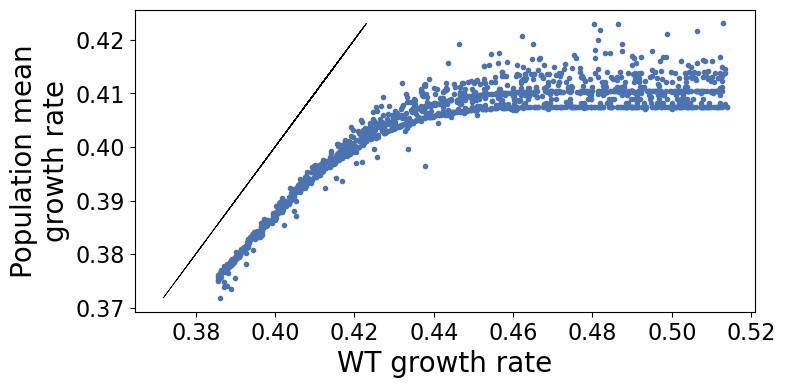

In [8]:
plt.figure(figsize=(8,4))
plt.plot( wtMU, np.mean(MU, axis=1), '.')
plt.plot(np.mean(MU, axis=1), np.mean(MU, axis=1), 'k', lw=0.5)
plt.ylabel('Population mean\ngrowth rate')
plt.xlabel('WT growth rate')

print('Linear rho = %1.4f' % np.corrcoef( np.mean(MU, axis=1), wtMU)[0,1] )

## Across all random media, we find two dominant regimes depending on the limiting components, which strongly determine $R^2$.


100%|██████████| 1724/1724 [00:00<00:00, 5143.77it/s]


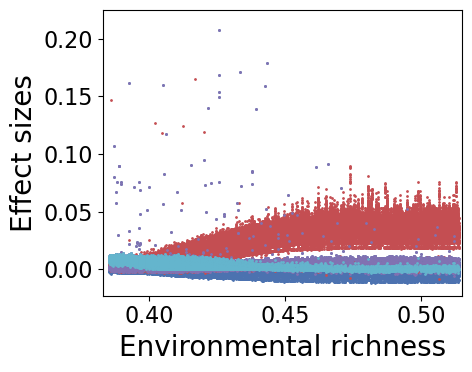

In [9]:
respiration_idx = np.array([ np.argwhere(Q.GENES==gene.id)[0] for gene in Q.model.reactions.get_by_id('CYOR_u6m').genes])
respiration_idx = respiration_idx.flatten()

thresh = 0.01
richness = wtMU # np.nanmean(MU, axis=1)

not_large = np.array([jj for jj in range(Q.N_GENES) if jj not in large ])
all_large= np.argwhere( np.any(BETAS>thresh, axis=0))[:,0]
new_large= np.array([ jj for jj in range(Q.N_GENES) if (jj in all_large) and (jj not in large) ])

MARKERSIZE = 2
MARKERALPHA = 1

plt.figure(figsize=(5,4), facecolor='w');
plt.plot(richness, BETAS[:,not_large],      '.', color=colors[0], lw=0.1, alpha=MARKERALPHA, ms=MARKERSIZE);
plt.plot(richness, BETAS[:,large],          '.', color=colors[2], lw=0.1, alpha=MARKERALPHA, ms=MARKERSIZE);
plt.plot(richness, BETAS[:,new_large],      '.', color=colors[3], lw=0.1, alpha=MARKERALPHA, ms=MARKERSIZE);
plt.plot(richness, BETAS[:,respiration_idx],'.', color=colors[5], lw=0.1, alpha=MARKERALPHA, ms=MARKERSIZE);


lst = []
for jj in tqdm(range(len(sigmaE))):
    if any(BETAS[jj,:]>thresh):
        for jj in np.argwhere(BETAS[jj,:]>thresh)[:,0]:
            if jj in new_large:
                lst.append( Q.GENES[jj])

ylims = plt.ylim()
plt.ylim( ylims[0], 0.225 )
plt.xlabel('Environmental richness')
plt.ylabel('Effect sizes');
plt.xlim(0.383,0.515)
plt.tight_layout();

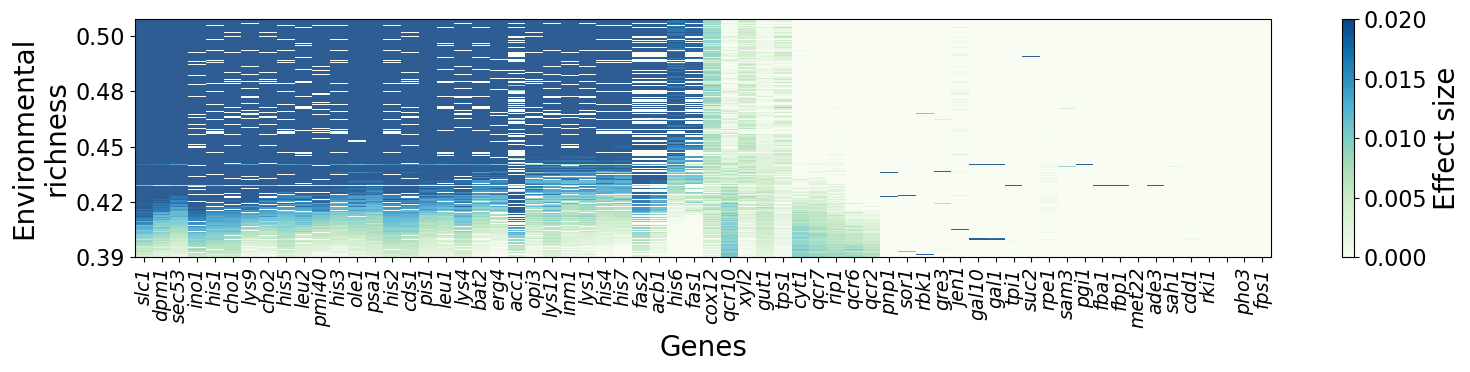

In [10]:
nonzero = np.argwhere( np.sum( 1*(BETAS>0.01), axis=0)>0 )[:,0]
meanbeta= np.mean( BETAS[:, nonzero], axis=0)
I = np.argsort(meanbeta)[-1::-1]
sorted_names = [ Q.model.genes.get_by_id( Q.GENES[gidx]).name.lower() for gidx in nonzero[I] ]


plt.figure( figsize=(16,4) )
plt.imshow( BETAS[:,nonzero[I]], aspect='auto', interpolation='none',vmin=0, vmax=0.02, cmap='GnBu', alpha=0.85)
plt.xticks( ticks=range(len(nonzero)), labels= sorted_names, style='italic', rotation=90, fontsize=0.85*SMALL_SIZE)
plt.colorbar(label='Effect size')
plt.xlabel('Genes')
plt.ylabel('Environmental\nrichness')

plt.tight_layout();
plt.gca().invert_yaxis()

ticks = np.arange(0,1601,400)
labels= [ "%1.2f" % wtMU[ int(idx)] for idx in ticks ]
plt.yticks( ticks=ticks, labels=labels) ;



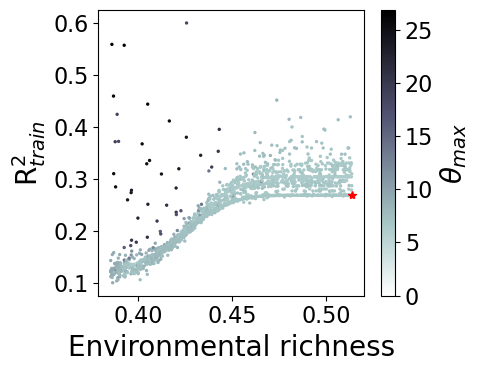

In [11]:
plt.figure( figsize=(5,4) )


plt.scatter( richness, R2_pps, 
            s = MARKERSIZE,
            c = (np.max(BETAS, axis=1)-np.mean(BETAS, axis=1))/np.std(BETAS, axis=1),
            cmap='bone_r',
            vmin=-0.02)
plt.plot( wt_growthrate, R2_std,'*r')
plt.colorbar(label=r'$\theta_{max}$')
plt.xlabel('Environmental richness')
plt.ylabel('R$^2_{train}$')
plt.tight_layout();

## Compute portability of PPS$_{std}$ 

In [12]:
R2_xpop=np.zeros((SAMPLES,))
Q.VERBOSE=False

for idx in tqdm(range(SAMPLES)):
    # Remove non-growing individuals
    _mu, _G = Q.clear_population( MU[idx,:] , MATRICES=[G_std,], minimal_gr=1e-2)   
    
    # Compute its true and expected growth rates
    #... normalize population and compute PPS
    X     = _G  - np.mean( _G , axis=0)
    y_fba = _mu - np.mean( _mu )
    y_pps = np.matmul( X , coef_std)
    
    R2_xpop[idx] = r2_score( y_fba, y_pps )

100%|██████████| 1724/1724 [01:32<00:00, 18.62it/s]


(0.0, 1.0)

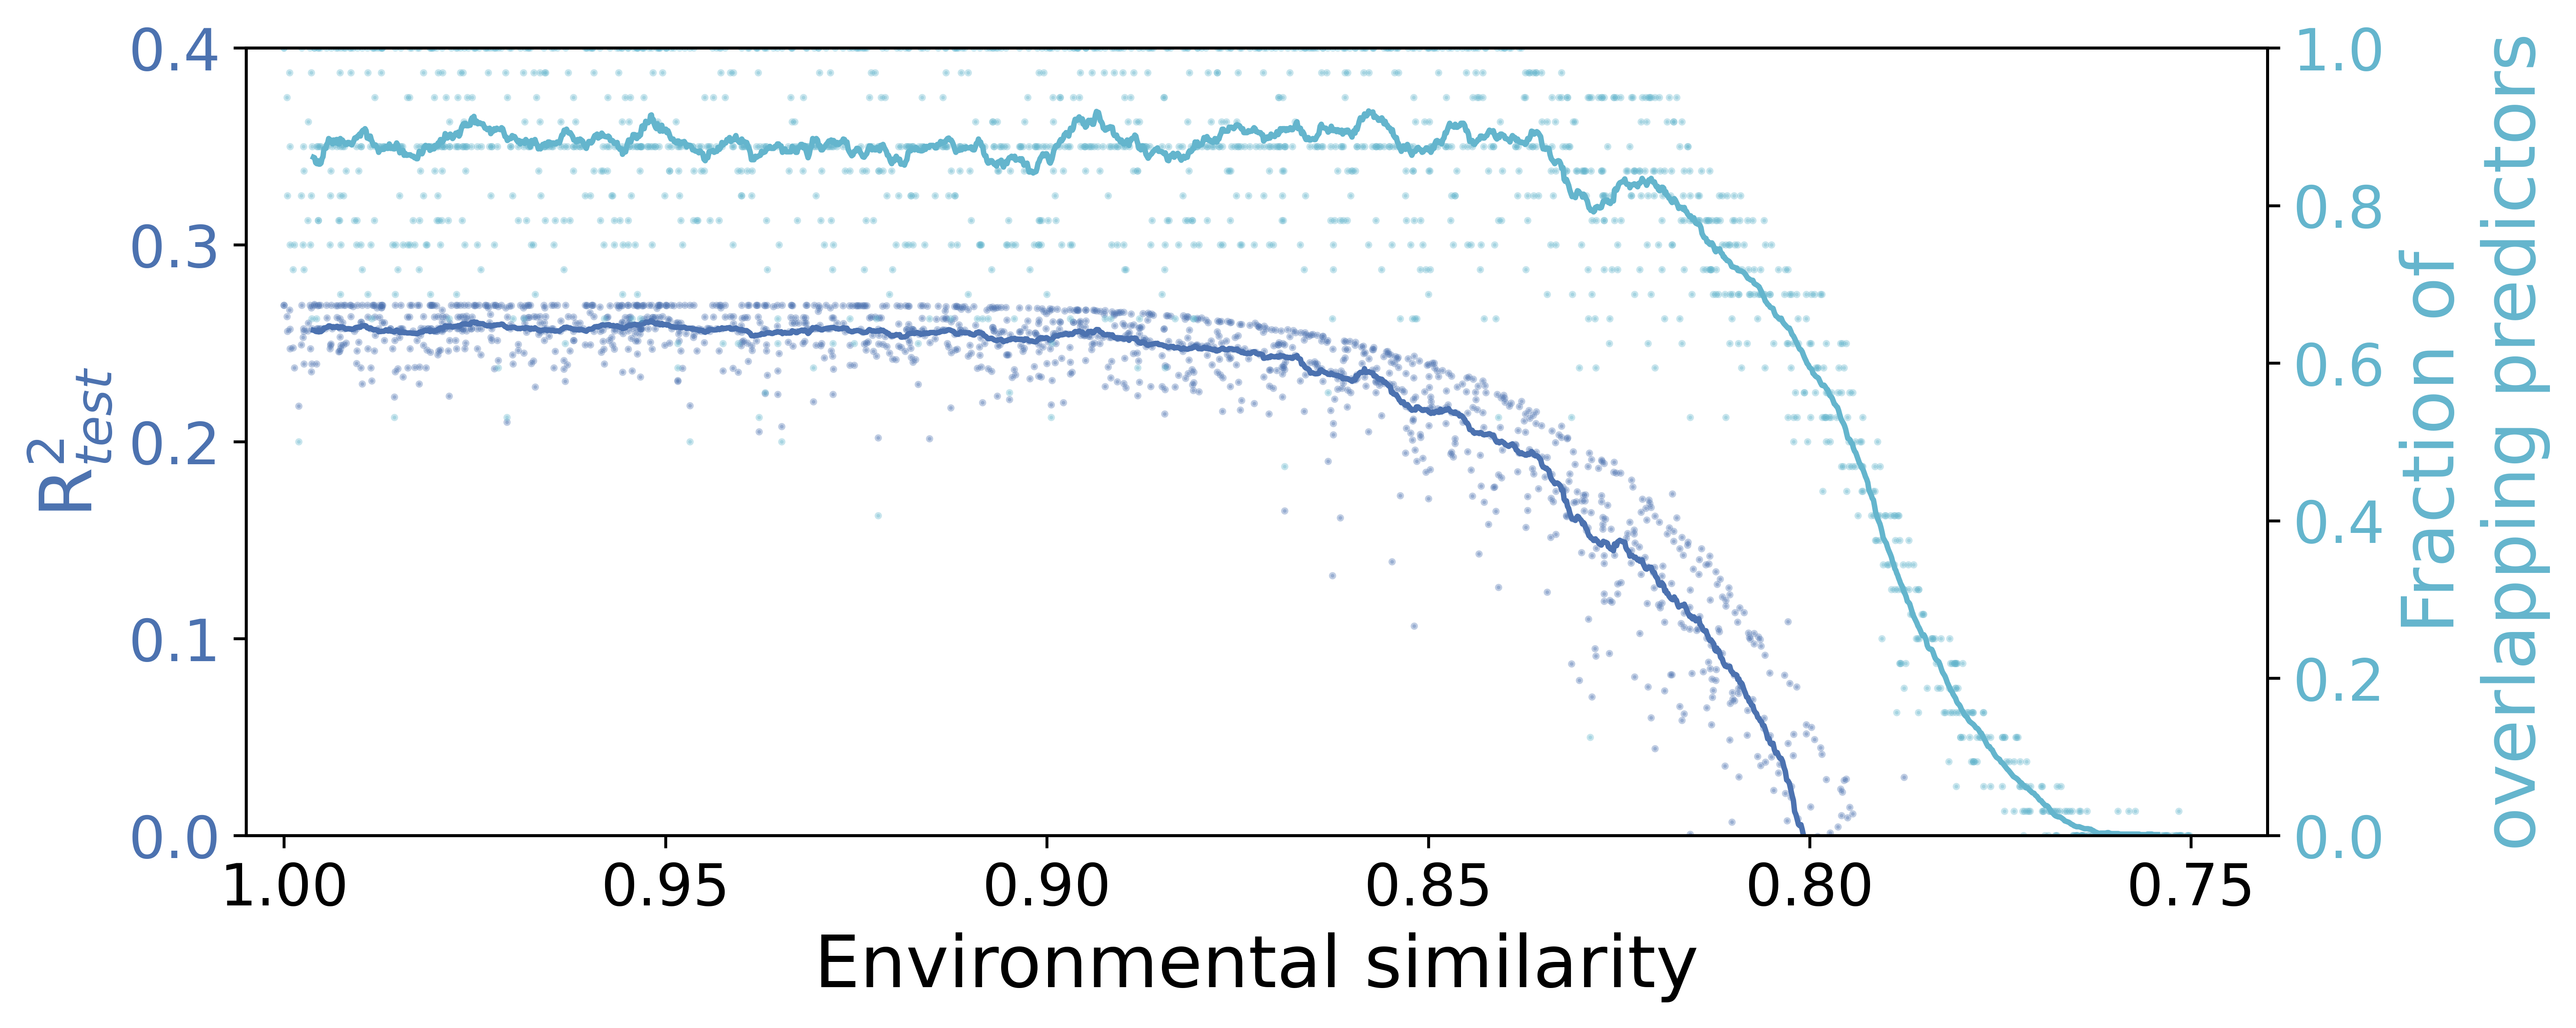

In [13]:
x_data = wtMU/wtMU.max()
y_data1= R2_xpop
y_data2=  np.sum( (BETAS[:,large]>0.01), axis=1) /  len(large)
N = 50

plt.figure( figsize=(10,4), dpi=600 )
# -- Left y-axis --
p = plt.plot( x_data, y_data1, '.', ms=MARKERSIZE, alpha=0.35, color=colors[0])
plt.plot( np.convolve( x_data, np.ones(N)/N, mode='valid'), np.convolve( y_data1, np.ones(N)/N, mode='valid'), '-', color=p[0].get_color())
plt.gca().tick_params(axis='y', labelcolor=p[0].get_color())
plt.xlim(0.74, 1.005)
plt.gca().invert_xaxis()
plt.ylabel('R$^2_{test}$', color=p[0].get_color())
plt.ylim(0,0.4)
plt.xlabel('Environmental similarity')


# -- Right y-axis --
axR=plt.gca().twinx()
p=axR.plot( x_data, y_data2, '.', ms=MARKERSIZE, color= colors[5], alpha=0.35) 
axR.plot( np.convolve( x_data, np.ones(N)/N, mode='valid'), np.convolve( y_data2, np.ones(N)/N, mode='valid'), '-', color=p[0].get_color())
axR.set_ylabel("Fraction of\noverlapping predictors" , color=p[0].get_color())
axR.tick_params(axis='y', labelcolor=p[0].get_color())
axR.set_ylim(0,1)

### Are all metabolisms similar across different environments?
#### How many reactions do they share in common?

In [14]:
thold  = 1e-10
shared_fluxes = np.zeros((SAMPLES, SAMPLES))

for ii in tqdm(range(SAMPLES)):
    for jj in range(SAMPLES):
        active_ii = np.abs( mJ[ii,:] ) > thold
        active_jj = np.abs( mJ[jj,:] ) > thold

        shared_fluxes[ii,jj] = np.sum( (1*active_ii - 1*active_jj)[active_ii] == 0 )/ np.sum(active_ii)


100%|██████████| 1724/1724 [02:49<00:00, 10.15it/s]


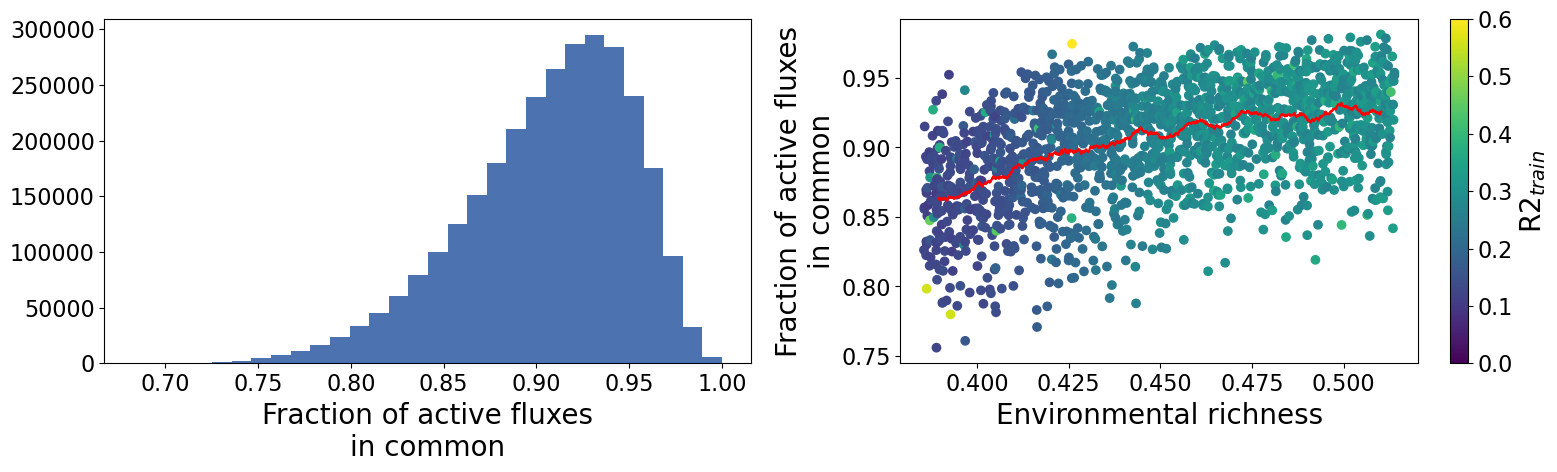

In [15]:
plt.figure( figsize=(16,5), dpi=100 )

plt.subplot(1,2,1)
#plt.imshow( shared_fluxes, aspect='auto')
#plt.colorbar(label='Fraction of active fluxes\nin common');
plt.hist( shared_fluxes.flatten(), bins=30)
plt.xlabel('Fraction of active fluxes\nin common')


plt.subplot(1,2,2)
plt.scatter( wtMU, np.mean(shared_fluxes, axis=0), c=R2_pps, vmin=0 )
N=100
plt.plot( np.convolve( wtMU, np.ones(N)/N, mode='valid'), np.convolve( np.mean(shared_fluxes, axis=0), np.ones(N)/N, mode='valid'), 'r-')
plt.ylabel('Fraction of active fluxes\nin common')

#plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()
plt.colorbar(label='R2$_{train}$')
plt.xlabel('Environmental richness')

plt.tight_layout();

0.4837420431684807 1.7940571963048824e-15
Partial correlation between R2_train and Metabolic distance, controlling for env. richness:
0.05796697690338903


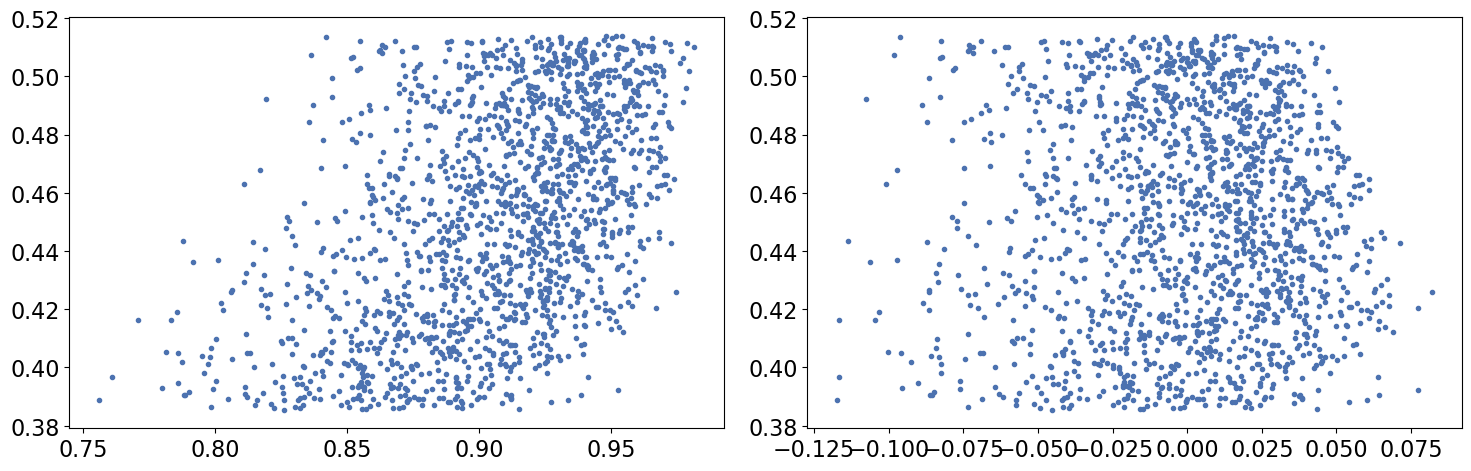

In [16]:
y = R2_pps
x = np.mean(shared_fluxes, axis=0)
z = wtMU

fitx = np.polyfit(z,x, deg=1)
fity = np.polyfit(z,y, deg=1)

_x = x - np.polyval( fitx, z)
_y = y - np.polyval( fity, z)

plt.figure( figsize=(15,5) )
plt.subplot(1,2,1)
plt.plot(x,z,'.')
plt.subplot(1,2,2)
plt.plot(_x, z,'.')

print( np.corrcoef(x,z)[0,1] , np.corrcoef(_x,z)[0,1] )
print('Partial correlation between R2_train and Metabolic distance, controlling for env. richness:')
print( np.corrcoef(_x,_y)[0,1])
plt.tight_layout();